# Theory

We consider the diffusion-advection problem
$$
    \mathcal{L}(u) : = -\kappa\Delta u + \beta\cdot u = f \quad x \in\Omega := (0,1)^2, \\
    u|_{\partial\Omega}=0.
$$
Here 
$$
    k=10^{-2}, \quad \beta = (\textstyle\frac{1}{2},1)\sqrt{\frac{4}{5}}, \quad f(x,y) =
    \begin{cases}
        +1 \text{  if  } y \ge 2x,\\
        -1 \text{  else}.
    \end{cases}
$$

We search for a solution by minimizing $\mathcal{L}(u)-f$ in the $L^2(\Omega)$ norm:
$$
    \|\mathcal{L}(u)-f\|_2 := \left[\int_\Omega |\mathcal{L}(u)-f|^2 \text{d}\mathbf{x}\right]^\frac{1}{2}.
$$

Since we have homogeneous Dirichlet boundary conditions, we can seek a solution of the form $u_{NN}\phi_{Hom BC}$, where $\phi_{Hom BC}: \overline{\Omega} \rightarrow [0,1]$ is a smooth function that is $0$ on $\partial\Omega$ and steeply goes to $1$ in $\Omega$ (see results below for details).

With the above method, the loss function for the PINN does not contain a term for the boundary. Choosing a set of collocation points $\mathbf{x}_1,\ldots,\mathbf{x}_n$, we can define the loss as a discrete approximation of $\|\mathcal{L}(u)-f\|_2$:
$$
    L(u) := \frac{1}{n}\sum_{i=1}^n \left|\mathcal{L}(u_{NN}\phi_{Hom BC})(\mathbf{x_i})-f(\mathbf{x}_i) \right|^2.
$$

Important to note here is that for the neural network to be aware of $\phi_{Hom BC}$, there must be enough collocation points in the steep part of $\phi_{Hom BC}$ close to $\partial\Omega$.

# Results

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from importlib import reload

import tensorflow as tf

In [2]:
import boundary
import domain
import network
import PINN

## Satisfying homogeneous Dirichlet boundary conditions on the rectangle $(0,L)\times(0,H)$

This function is given by $f(x;\alpha,L)f(y;\alpha,H)$, where
$$
    f(x;\alpha,L) = \left(1-e^{-\frac{\alpha x}{L}}\right)\left(1-e^{-\frac{\alpha (L-x)}{L}}\right).
$$

<IPython.core.display.Javascript object>


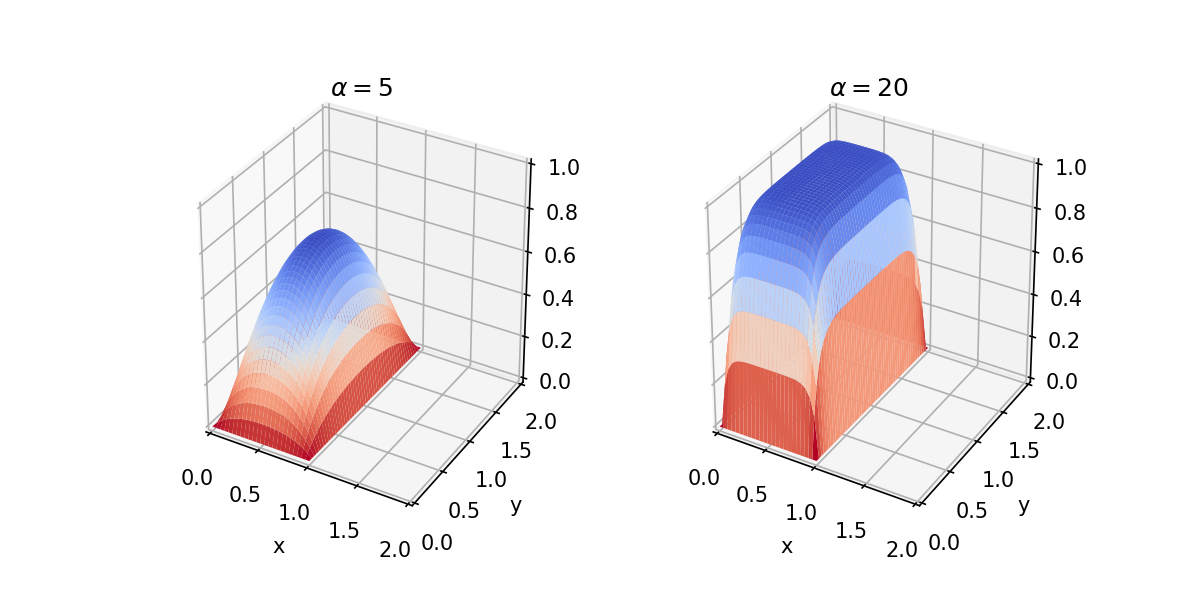

In [3]:
reload(domain)

L  = 1
H  = 2
D  = domain.rectangular_domain(L=L, H=H, plotting_pixdens = 25)

fig = plt.figure(figsize=(8,4))

for ax_loc,alpha in zip([121,122],[5,20]):
    
    HD = boundary.hom_dirichlet_2D(D.x_grid,D.y_grid,alpha,L,H)
    ax = fig.add_subplot(ax_loc,projection = '3d')
    
    ax.plot_surface(D.x_grid,D.y_grid, HD.reshape(D.plotting_gridshape), cmap = 'coolwarm_r')
    ax.set_xlim(0,max(L,H))
    ax.set_ylim(0,max(L,H))
    ax.set_zlim(0,1)
    ax.set_title(f"$\\alpha = {alpha}$")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
fig.canvas.draw();

## Sampling points in the domain

Note: there must be enough sampling points in the steep parts of the functions above

<IPython.core.display.Javascript object>


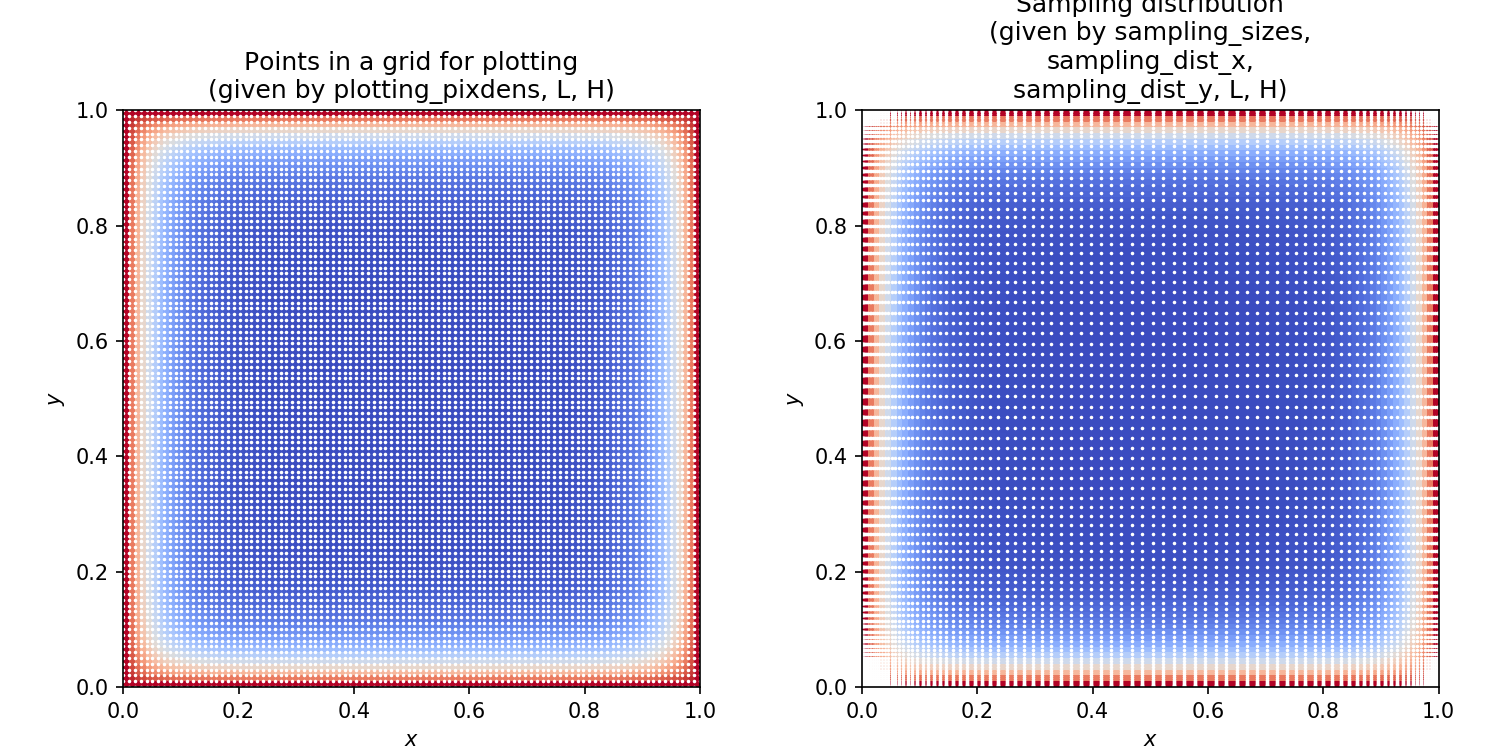

In [4]:
L     = 1
H     = 1
alpha = 20

def scatter_samples(ax, samples):
    ax.scatter(samples[:,0],samples[:,1], s = 0.5, color = 'w')

D    = domain.rectangular_domain(L=L, H=H, plotting_pixdens = 100, sampling_sizes = (100,100),
                                 sampling_dist_x = lambda x: np.sin(np.pi*x/2)**3,
                                 sampling_dist_y = lambda y: np.sin(np.pi*y/2)**3)

fig, axs = plt.subplots(1,2, figsize = (10*L,5*H))

axs[0].set_title("Points in a grid for plotting\n(given by plotting_pixdens, L, H)")
scatter_samples(axs[0],D.plotting_grid)

D.update_samples()

axs[1].set_title("Sampling distribution\n(given by sampling_sizes,\nsampling_dist_x,\nsampling_dist_y, L, H)")
scatter_samples(axs[1],D.samples)

HD = boundary.hom_dirichlet_2D(D.plotting_grid[:,0],D.plotting_grid[:,1],alpha,L,H).reshape(D.plotting_gridshape)

for ax in axs:
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect('equal','box')
    ax.imshow(HD, extent = [0,L,0,H], cmap = 'coolwarm_r')
    
fig.tight_layout()
fig.canvas.draw();

## Initiate PINN

In [7]:
# Neural network in keras
Model = network.construct_model(hidden_layer_widths = np.array(7*[10]),
                                activation_function = tf.nn.tanh)

# Optimizer
Optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,
                                     beta_1=0.99,
                                     epsilon=1e-1) 

# RHS function in the PDE
def f(x,y):
    
    if y >= 2*x:
        return 1
    else:
        return -1
    
f = np.vectorize(f)

# PINN object to perform training
NN = PINN.PINN_object(D, Model, Optimizer, RHS_f = f, alpha = alpha)

## Train PINN

<IPython.core.display.Javascript object>


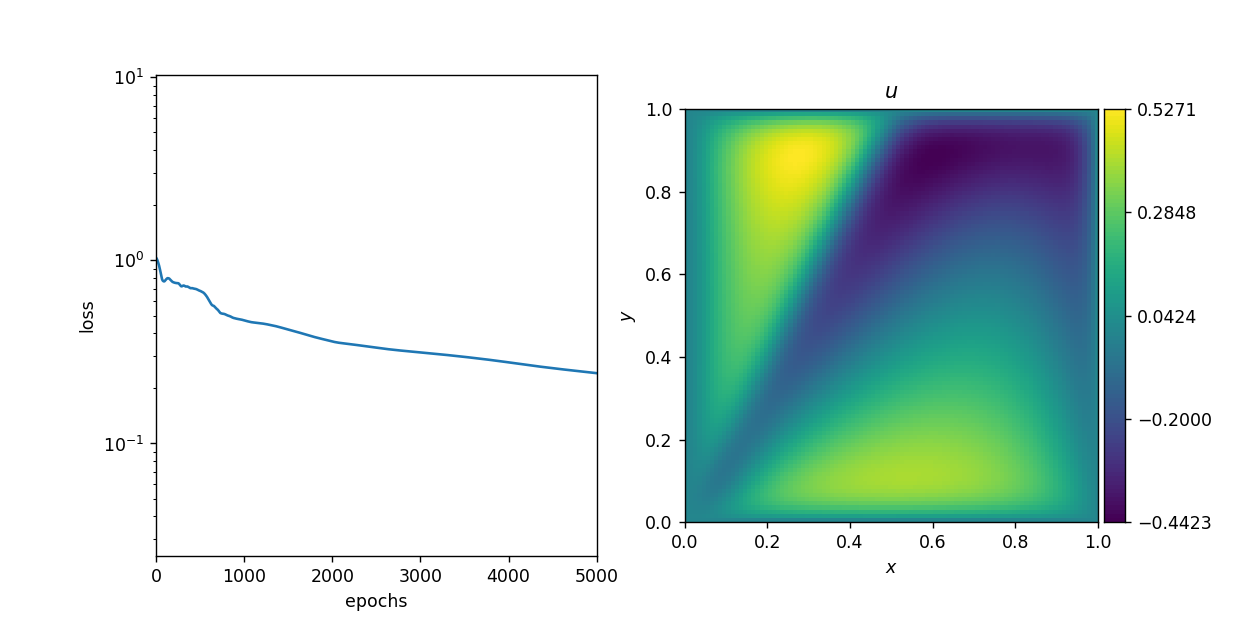

In [8]:
NN.fit(n_epochs = 5000,
       plot_update_interval = 100);